Some comments on the inverter
* We are using a MLP as inverter that maps the graph to latent features. 
    * Could be other models as well. 
* The initialized inverter should contain a Graph2Vec embedding module, and each forward pass of the inverter should: 
    1. Embed a graph adjacency matrix using graph2vec
    2. Pass it through the layers 
    3. Optimize the model against the target equation (reconstruction error)
* Built from the template provided by Winston Yu 

Here is the target loss function: 
$$\min_{\gamma} \mathbb{E}_{x \sim p_{x}(x)} \lVert \mathbb{G}_{\theta}(\mathbb{I}_{\gamma}(x)) - x \rVert + \lambda \cdot \mathbb{E}_{z \sim p_{z}(z)}[\mathbb{L}(z, \mathbb{I}_{\gamma}(\mathbb{G}_{\theta}(z)))]$$

In [37]:
# the target loss function 
import torch
from torch import nn
from scipy.stats import wasserstein_distance

def choose_device(): 
    if torch.cuda.is_available(): 
        return 'cuda'
    elif torch.backends.mps.is_available(): 
        return 'mps'
    else: 
        return 'cpu'

class WGAN_ReconLoss(nn.Module): 
    def __init__(self, lamb: float, loss_func: str='MSE', device=choose_device()) -> None:
        super().__init__()
        self.lamb = lamb 
        self.device = device
        if loss_func == 'MSE': 
            self.L = nn.MSELoss(reduction='mean').to(self.device)
        elif loss_func == 'CrossEntropy': 
            self.L = nn.CrossEntropyLoss().to(self.device)
        else: 
            print("Loss function must be 'MSE' or 'CrossEntropy'.")
        
            
    def forward(self, x_original, x_reconst, z_original, z_reconst, use_gw1=True): 
        """
        From the Generating Natural Adv. Example Paper: 
            x_original: original image/graph example 
            x_reconst: reconstruction of that image/graph from the generator
            z_original: noise or learned latent feature passed into the inverter 
            z_reconst: reconstruction of the noise, output of the inverter 
        """
        if use_gw1: 
            return (self.L(x_original, x_reconst) + self.lamb * self.L(z_original, z_reconst)).to(self.device)
        else:
            return (wasserstein_distance(x_original, x_reconst) + self.lamb * self.L(z_original, z_reconst)).to(self.device)
        

"""
Example from solver.py 
reconst_images = self.G(self.I(images))
reconst_noise = self.I(self.G(noise))

i_loss = torch.mean((images-reconst_images)**2) + self.lambda_i * torch.mean((noise-reconst_noise)**2)
"""
None

In [38]:
recloss = WGAN_ReconLoss(lamb=0.1)
result = recloss(torch.Tensor([[100, 100], [100, 100]]), torch.Tensor([[200, 2000],  [100, 100]]), torch.Tensor([200]), torch.Tensor([100]))

In [39]:
result.is_mps

True

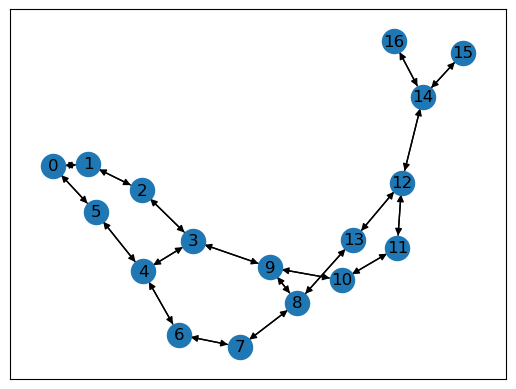

In [30]:
# create list of networkx graphs 
import networkx as nx 
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
dataset = TUDataset(root='../data/raw/TUDataset', name='MUTAG')
graphs = [to_networkx(data) for data in dataset]
nx.draw_networkx(graphs[0])

In [32]:
# default 10 epochs 
from karateclub import Graph2Vec
graph2vec = Graph2Vec(workers=-1)
graph2vec.fit(graphs)

In [36]:
import torch
torch.Tensor(graph2vec.get_embedding())

tensor([[ 0.0062,  0.0073,  0.0062,  ...,  0.0050,  0.0030,  0.0051],
        [ 0.0018,  0.0077, -0.0024,  ..., -0.0037,  0.0039, -0.0009],
        [ 0.0059, -0.0010, -0.0067,  ..., -0.0047, -0.0076,  0.0072],
        ...,
        [-0.0062,  0.0035, -0.0024,  ...,  0.0030, -0.0052, -0.0024],
        [ 0.0031,  0.0064,  0.0029,  ...,  0.0044,  0.0054, -0.0011],
        [ 0.0045, -0.0010,  0.0043,  ...,  0.0034,  0.0008,  0.0059]])